In [1]:
import numpy as np
import pandas as pd

In [2]:
want_new_data = False

if want_new_data:
    data = pd.read_pickle('crafted_data/playlists_and_trackid.pkl')
    data = data[data['num_tracks_id'] >= 10]
    max_length = max(data['num_tracks_id'])

    numerical_values = pd.read_pickle('src/tracks_numerical_features.pkl')
    numerical_values = numerical_values.set_index('id')
    X = []
    y = []
    for playlist in data['tracks']:
        curr = []
        for i in range(len(playlist)):
            
            song_id = playlist[i]
            if (i == len(playlist) - 1):
                y.append(np.array(numerical_values.loc[song_id].values))
            else:
                curr.append(np.array(numerical_values.loc[song_id].values))
        to_pad = max_length - len(curr) - 1
        tmp = np.array(curr)
        tmp = np.pad(tmp, pad_width=((to_pad,0), (0,0)), mode='constant')
        X.append(np.array(tmp))
    X = np.array(X)
    y = np.array(y)
    np.save('crafted_data/X', X)
    np.save('crafted_data/y', y)
else:
    X = np.load('crafted_data/X.npy')
    y = np.load('crafted_data/y.npy')

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (2058, 120, 13)
y shape:  (2058, 13)


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Epoch 1/20
22/26 [========================>.....] - ETA: 0s - loss: 442.9284 - mse: 442.9284
Epoch 1: val_loss improved from inf to 117.77413, saving model to models/cnn/best_cnn.hdf5
26/26 [==============================] - 0s 11ms/step - loss: 395.3067 - mse: 395.3067 - val_loss: 117.7741 - val_mse: 117.7741
Epoch 2/20
21/26 [=======================>......] - ETA: 0s - loss: 107.3783 - mse: 107.3783
Epoch 2: val_loss improved from 117.77413 to 81.98257, saving model to models/cnn/best_cnn.hdf5
26/26 [==============================] - 0s 9ms/step - loss: 101.2469 - mse: 101.2469 - val_loss: 81.9826 - val_mse: 81.9826
Epoch 3/20
22/26 [========================>.....] - ETA: 0s - loss: 75.4173 - mse: 75.4173
Epoch 3: val_loss improved from 81.98257 to 78.50364, saving model to models/cnn/best_cnn.hdf5
26/26 [==============================] - 0s 9ms/step - loss: 77.2053 - mse: 77.2053 - val_loss: 78.5036 - val_mse: 78.5036
Epoch 4/20
22/26 [========================>.....] - ETA: 0s - los

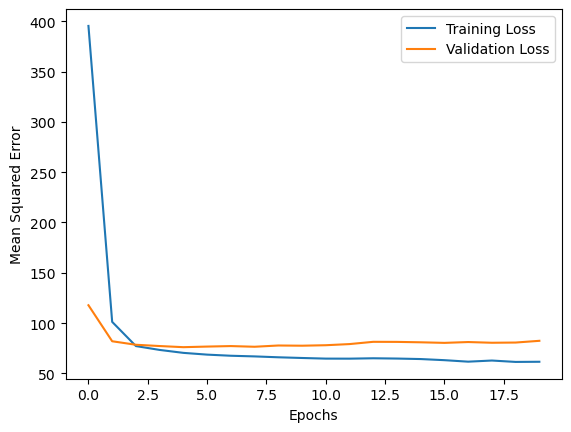

13/13 [==============================] - 0s 2ms/step
Best model MSE on test data =  70.46772


In [5]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, load_model
from keras.datasets import boston_housing
from keras.losses import MeanSquaredError

# hyperparameters
INPUT_SIZE = (X.shape[1], X.shape[2], 1)
HIDDEN_SIZE = 10
EPOCHS = 20
BATCH_SIZE = 64
lr = 0.1

#Create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
model.add(Flatten())
model.add(Dense(13, activation='linear'))

mse = MeanSquaredError()
adam = optimizers.Adam(learning_rate=lr, decay=1e-3)
model.compile(optimizer=adam, loss=mse, metrics = None)

filepath = 'models/cnn/best_cnn.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint]

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

data = X.reshape(X.shape[0],X.shape[1], X.shape[2], 1)

history = model.fit(data, y, batch_size=BATCH_SIZE, epochs=EPOCHS,
                  validation_split=0.2,
                  callbacks=callbacks)

#plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.savefig('images/cnn_training_history')
plt.show()

#Load and evaluate the best model version
model = load_model(filepath)
yhat = model.predict(X_test)
print('Best model MSE on test data = ', mse(y_test, yhat).numpy())